# Expexted Return Modelling

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold

In [2]:
data_folder = "data"
stack_name = os.path.join(data_folder, "data_stack.h5")
df_stack = pd.read_hdf(stack_name)

In [3]:
is_ratio = 0.7
isos_split = df_stack.index[int(len(df_stack)*is_ratio)][0]
df_stack_is = df_stack[df_stack.index.get_level_values(0)<isos_split]
df_stack_os = df_stack[df_stack.index.get_level_values(0)>=isos_split]

is_name = os.path.join(data_folder, "df_is.h5")
df_stack_is.to_hdf(is_name, key='df', mode='w', format="table")
os_name = os.path.join(data_folder, "df_os.h5")
df_stack_os.to_hdf(os_name, key='df', mode='w', format="table")

df_stack_is_c = df_stack_is.copy()
df_stack_os_c = df_stack_os.copy()

features = list(df_stack_is_c.columns)[:-1]
target = list(df_stack_is_c.columns)[-1]

In [4]:
def zscore_scaling(train, test):
    train_mean = train.mean()
    train_std = train.std()
    train = (train - train_mean) / train_std
    test = (test - train_mean) / train_std
    return train, test

In [5]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
}

In [6]:
X = df_stack_is_c[features]
y = df_stack_is_c[target]

In [7]:
kf_results = []
tscv_results = []
eval_metric = 'mae'

# 5-fold CV with initial tuning
kf = KFold(n_splits=5)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    # time series consistency
    valid_start = X_valid.index.get_level_values(0)[0]
    valid_end = X_valid.index.get_level_values(0)[-1]
    
    if fold == 0:
        X_train = X[X.index.get_level_values(0)>valid_end]
        X_valid = X[X.index.get_level_values(0)<=valid_end]
        y_train = y[y.index.get_level_values(0)>valid_end]
        y_valid = y[y.index.get_level_values(0)<=valid_end]
    elif fold == 5:
        X_train = X[X.index.get_level_values(0)<valid_start]
        X_valid = X[X.index.get_level_values(0)>=valid_start]
        y_train = y[y.index.get_level_values(0)<valid_start]
        y_valid = y[y.index.get_level_values(0)>=valid_start]
    else:
        X_train = X[(X.index.get_level_values(0)<valid_start)|(X.index.get_level_values(0)>valid_end)]
        X_valid = X[(X.index.get_level_values(0)>=valid_start)&(X.index.get_level_values(0)<=valid_end)]
        y_train = y[(y.index.get_level_values(0)<valid_start)|(y.index.get_level_values(0)>valid_end)]
        y_valid = y[(y.index.get_level_values(0)>=valid_start)&(y.index.get_level_values(0)<=valid_end)]
        
    # embargo 1 month
    if fold > 0:
        dt = X_valid.index.get_level_values(0)[0]
        X_valid = X_valid[X_valid.index.get_level_values(0)>dt]
        y_valid = y_valid[y_valid.index.get_level_values(0)>dt]
    else:
        pass
    
    # z-scoring target variable
    y_train, y_valid = zscore_scaling(y_train, y_valid)
    
    model = xgb.XGBRegressor(enable_categorical=True,
                             eval_metric=eval_metric)

    grid_search = GridSearchCV(model, param_grid,
                               scoring='neg_mean_absolute_error', cv=3)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    initial_model = xgb.XGBRegressor(enable_categorical=True,
                                     eval_metric=eval_metric, **best_params)
    initial_model.fit(X, y)

    y_pred_kf = initial_model.predict(X_valid)
    mae_kf = mean_absolute_error(y_valid, y_pred_kf)
    kf_results.append(mae_kf)

    print(f'K-Fold Split {fold + 1} MAE: {mae_kf:.4f}')

kf_mean_mae = np.mean(kf_results)
print(f'K-Fold Mean MAE: {kf_mean_mae:.4f}')

# TSCV with further fine-tuning
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, valid_idx) in enumerate(tscv.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # time series consistency
    valid_start = X_valid.index.get_level_values(0)[0]
    valid_end = X_valid.index.get_level_values(0)[-1]

    X_train = X[X.index.get_level_values(0)<valid_start]
    X_valid = X[X.index.get_level_values(0)>=valid_start]
    y_train = y[y.index.get_level_values(0)<valid_start]
    y_valid = y[y.index.get_level_values(0)>=valid_start]
    
    # z-scoring target variable
    y_train, y_valid = zscore_scaling(y_train, y_valid)
    
    # update pre-fit model
    updated_model = initial_model

    grid_search_wf = GridSearchCV(updated_model, param_grid,
                                  scoring='neg_mean_absolute_error', cv=3)
    grid_search_wf.fit(X_train, y_train)

    best_params_updated = grid_search_wf.best_params_
    updated_model.set_params(**best_params_updated)

    updated_model.fit(X_valid, y_valid)

    y_pred_tscv = updated_model.predict(X_valid)
    mae_tscv = mean_absolute_error(y_valid, y_pred_tscv)
    tscv_results.append(mae_tscv)

    print(f'TSCV Split {fold + 1} MAE: {mae_tscv:.4f}')

tscv_mean_mae = np.mean(tscv_results)
print(f'TSCV Mean MAE: {tscv_mean_mae:.4f}')

K-Fold Split 1 MAE: 0.7679
K-Fold Split 2 MAE: 0.7474
K-Fold Split 3 MAE: 0.8892
K-Fold Split 4 MAE: 0.7228
K-Fold Split 5 MAE: 0.6811
K-Fold Mean MAE: 0.7617
TSCV Split 1 MAE: 0.7478
TSCV Split 2 MAE: 0.7914
TSCV Split 3 MAE: 0.6948
TSCV Split 4 MAE: 0.6940
TSCV Split 5 MAE: 0.6477
TSCV Mean MAE: 0.7151


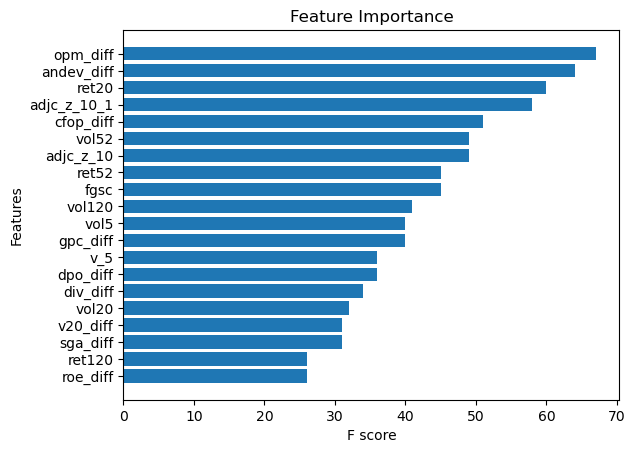

In [8]:
model_folder = "model"
importance_name = os.path.join(model_folder, "importance.jpg")

topn = 20
scores_dict = updated_model.get_booster().get_fscore()
top_scores = pd.Series(scores_dict).sort_values(ascending=False).iloc[:topn]
top_scores = top_scores.sort_values()

fig1, ax1 = plt.subplots()
ax1.barh(top_scores.index, top_scores)
ax1.set_title("Feature Importance")
ax1.set_ylabel("Features")
ax1.set_xlabel("F score")

fig1.figure.savefig(importance_name, dpi=300, bbox_inches='tight')

In [9]:
x_is = df_stack_is_c[features]
y_is = df_stack_is_c[target]
y_is_predict = updated_model.predict(x_is)

x_os = df_stack_os_c[features]
y_os = df_stack_os_c[target]
y_os_predict = updated_model.predict(x_os)

# zscore with last y_valid
y_last_valid = y[y.index.get_level_values(0)>=valid_start]
_, y_is_scaled = zscore_scaling(y_last_valid, y_is)
_, y_os_scaled = zscore_scaling(y_last_valid, y_os)

is_score = mean_absolute_error(y_is, y_is_predict)
os_score = mean_absolute_error(y_os, y_os_predict)

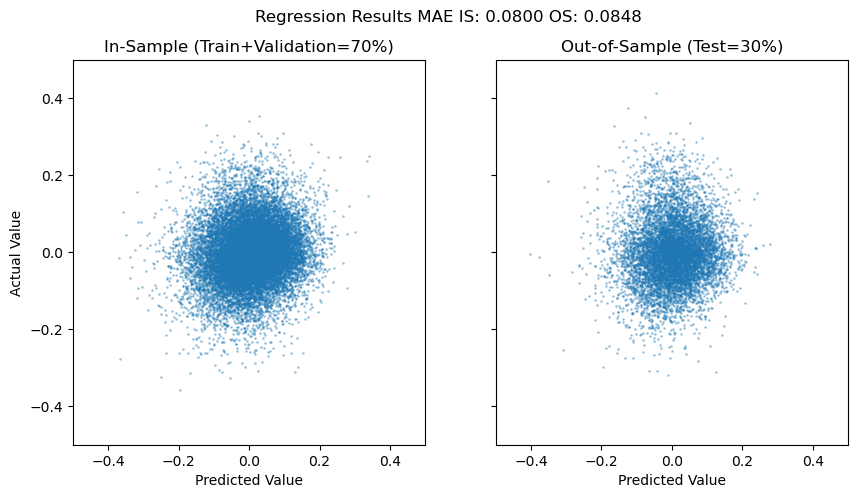

In [10]:
regression_name = os.path.join(model_folder, "regression.jpg")

fig2, ax2 = plt.subplots(1,2, figsize=(10,5), sharey=True)
fig2.suptitle(f"Regression Results {eval_metric.upper()} IS: {is_score:.4f} OS: {os_score:.4f}")


sns.scatterplot(x=y_is_predict, y=y_is, ax=ax2[0], s=3, linewidth=0, alpha=0.5)
sns.scatterplot(x=y_os_predict, y=y_os, ax=ax2[1], s=3, linewidth=0, alpha=0.5)

ax2[0].set_xlim([-0.5, 0.5])
ax2[1].set_xlim([-0.5, 0.5])
ax2[0].set_ylim([-0.5, 0.5])
ax2[1].set_ylim([-0.5, 0.5])

ax2[0].set_title(f"In-Sample (Train+Validation={is_ratio*100:.0f}%)")
ax2[1].set_title(f"Out-of-Sample (Test={(1-is_ratio)*100:.0f}%)")
ax2[0].set_xlabel("Predicted Value")
ax2[0].set_ylabel("Actual Value")
ax2[1].set_xlabel("Predicted Value")
ax2[1].set_ylabel("Actual Value")

fig2.figure.savefig(regression_name, dpi=300, bbox_inches='tight')

In [11]:
model_name = os.path.join(model_folder, "xgb.json")
updated_model.save_model(model_name)